In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "mango_filtered.csv"
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']
n_comps = [i for i in range(1,101)]
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/3.01_correct") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\3.01_correct\mango_filtered


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 190)


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [4]:
# set logging, in this case the root logger

ut.setup_logger(logger_name="log",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="test_log",file_name=log_dir/"test_log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")

if True:
    #step 1, run pls, set up pls - that runs best
    n_comps = [i for i in range(1,101)]
    pls_models = {i:PLSRegression(n_components=i) for i in n_comps}

    pls_scheme = SKLearnScheme(logger="log")
    scores_pls, preds_pls, model_states_pls , train_time_pls, test_time_pls = eval.evaluate(pls_models,dataset,pls_scheme,logger_name="log")
    summary_logger.info(f"Train times: {train_time_pls}")
    summary_logger.info(f"Test times: {test_time_pls}")
    from collections import defaultdict
    summary_logger.info(f"Scores: {scores_pls}")
    for key,value in flip_dicts(scores_pls).items():
        summary_logger.info(f"{key}: {value}")

    selected_comps =  min(scores_pls["mean"],key=scores_pls["mean"].get)
    summary_logger.info(f"Selected pls preprocessing with {selected_comps} components")
#selected_comps = 40

eval.preprocessing = Preprocess_Std()

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of 1:5.0624,2:4.9201,3:4.8173,4:4.5751,5:4.4089,6:4.0214,7:3.5985,8:2.5751,9:2.1412,10:1.4447,11:1.2348,12:1.1655,13:0.897,14:0.8473,15:0.7751,16:0.7466,17:0.7368,18:0.7214,19:0.7084,20:0.7019,21:0.6924,22:0.6845,23:0.6783,24:0.6729,25:0.6652,26:0.6584,27:0.6506,28:0.6444,29:0.6397,30:0.6366,31:0.6336,32:0.6297,33:0.6234,34:0.6193,35:0.6167,36:0.6146,37:0.6126,38:0.6099,39:0.6081,40:0.6064,41:0.6054,42:0.6039,43:0.6023,44:0.6014,45:0.6002,46:0.5994,47:0.5987,48:0.5983,49:0.5972,50:0.5968,51:0.5962,52:0.5957,53:0.5953,54:0.5949,55:0.5942,56:0.5939,57:0.5935,58:0.593,59:0.5924,60:0.5921,61:0.5916,62:0.5911,63:0.5908,64:0.5904,65:0.5901,66:0.5898,67:0.5896,68:0.5895,69:0.5893,70:0.5892,71:0.5891,72:0.589,73:0.5889,74:0.5888,75:0.5887,76:0.5886,77:0.5885,78:0.5884,79:0.5883,80:0.5882,81:0.5881,82

### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [5]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=selected_comps,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

deep_models = {name:RandomNet(input_size=n_features,
                             n_layers=config.n_layers,
                             act_function=config.act_function,
                             n_features = config.n_features,
                             dropout=config.dropout,
                             batch_norm=config.batch_norm,
                             device=device,dtype=torch.float)
              for name, config in configs.items()}

ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(deep_models,configs,log_dir)
start = datetime.datetime.now()
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores_deep, preds_deep, model_states_deep , train_time_deep, test_time_deep = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log")

scores_final, preds_final, model_states_ls_final , train_time_deep_final, test_time_deep_final = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log")
for model, state_dict in model_states_ls_final.items():
    torch.save(state_dict, log_dir / "models" / f"{model}" / f"_final")

summary_logger.info(f"Train times: {train_time_deep}")
summary_logger.info(f"Test times: {test_time_deep}")
from collections import defaultdict

Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Training extractors on 5879 instances, validating on 1929 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.581204),random_2:9437192.0769(-0.901208),random_3:nan(-0.56051),random_4:nan(-0.510167),random_5:12687.3287(-0.980977),random_6:176531241.9692(-0.924832),random_7:nan(-0.940597),random_8:11.6138(-0.73093),random_9:10.5205(-0.997069),random_10:nan(-0.75437),random_11:nan(-0.056796),random_12:nan(-0.025345),random_13:nan(-0.385566),random_14:nan(-0.286027),random_15:13.2088(-0.862446),random_16:nan(-0.447822),random_17:13.0978(-0.259096),random_18:18.406(-0.033556),random_19:nan(-0.232474),random_20:165.226(-0.684561),random_21:nan(-0.111175),random_22:nan(-0.105224),random_23:8.3701(-0.728931),rando

In [6]:
ex.save_results(model_states_deep, preds_deep,configs, scores_deep, log_dir,tb,prefix="")

#summary_logger.info(f"Scores: {scores_deep}")
#for key,value in flip_dicts(scores_deep).items():
#    summary_logger.info(f"{key}: {value}")

end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, deep_models, scores_deep,prefix="")
ex.save_pred_plots(preds_deep, deep_models,log_dir)


Experiments took 8:07:13.697447'
Finished Random Deep Search'
---Loss results---'
0 - random_66 - fold_0:0.6119,fold_1:0.654,fold_2:0.6459,fold_3:0.5319,fold_4:0.63,mean:0.6147'
1 - random_39 - fold_0:0.6123,fold_1:0.6512,fold_2:0.6731,fold_3:0.5455,fold_4:0.609,mean:0.6182'
2 - random_32 - fold_0:0.6255,fold_1:0.6317,fold_2:0.6642,fold_3:0.5411,fold_4:0.6383,mean:0.6201'
3 - random_45 - fold_0:0.6321,fold_1:0.6841,fold_2:0.6677,fold_3:0.5414,fold_4:0.6458,mean:0.6342'
4 - random_8 - fold_0:0.6295,fold_1:0.665,fold_2:0.6709,fold_3:0.6189,fold_4:0.6418,mean:0.6452'
5 - random_41 - fold_0:0.6438,fold_1:0.7032,fold_2:0.6939,fold_3:0.5831,fold_4:0.6507,mean:0.6549'
6 - random_55 - fold_0:0.6456,fold_1:0.6808,fold_2:0.6895,fold_3:0.6043,fold_4:0.6941,mean:0.6629'
7 - random_50 - fold_0:0.6839,fold_1:0.7152,fold_2:0.7033,fold_3:0.6045,fold_4:0.6925,mean:0.6799'
8 - random_92 - fold_0:0.705,fold_1:0.7087,fold_2:0.7169,fold_3:0.5867,fold_4:0.7051,mean:0.6845'
9 - random_53 - fold_0:0.6911,fold

### Plotting deep results as a function of number of features

In [7]:
scores_df = pd.DataFrame(scores_deep)
scores_df.to_csv(log_dir / f"scores.csv", index=False)


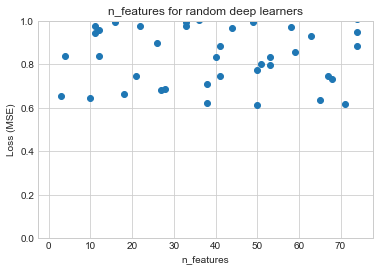

In [8]:
if True:
    # plot deep results as a function of number of features
    from matplotlib import pyplot as plt
    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["mean"][name],n_features_dict[name]] for name in scores_deep["mean"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.scatter(to_plot["n_features"],to_plot["score"])
    ax.set_ylim(0,1)
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("n_features")
    ax.set_ylabel("Loss (MSE)")
    ax.set_title("n_features for random deep learners")
    plt.savefig(log_dir / f"pp_deep_pls.png",bbox_inches='tight')
    ax.set_ylim(0,1)
    plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [9]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val - Score - Test Score")
for i,key in enumerate(sorted(scores_deep['mean'],key=scores_deep['mean'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores_deep['mean'][key]} - {scores_final['mean'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val - Score - Test Score'
0 - random_66 - 0.6147283610044848 - 0.6278428204810422'
1 - random_39 - 0.6182177267889989 - 0.6510427864216968'
2 - random_32 - 0.6201477241239569 - 0.6472715610298663'
3 - random_45 - 0.6342025625755124 - 0.6699985800856385'
4 - random_8 - 0.6452316378665506 - 0.6463144233872219'
